In [1]:
import pickle
import nltk
import numpy as np
import pandas as pd
import modelmetrics

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [14]:
data = pd.read_csv('Data/trustpilot.csv')
neutral_range = {"low": 2, "neutral": 5, "high": 8}
data["sentiment"].loc[data["rating"] <= neutral_range["low"]] = "negative"
data["sentiment"].loc[data["rating"] >= neutral_range["high"]] = "positive"
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment2'] = data['sentiment'].replace(sentiment_map)
data.head(50)

/var/folders/f4/g09hx1n5747dttb_p424s85w0000gn/T/ipykernel_26878/3420012934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"].loc[data["rating"] <= neutral_range["low"]] = "negative"
/var/folders/f4/g09hx1n5747dttb_p424s85w0000gn/T/ipykernel_26878/3420012934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"].loc[data["rating"] >= neutral_range["high"]] = "positive"


,company,title,body,rating,sentiment,sentiment2
0,PostNord i Danmark,Tjekker ikke modtagerflex,Pakken blev sat foran min hoveddør (med risiko...,1,negative,-1
1,PostNord i Danmark,En seriøst Postmand smider ikke en…,En seriøst Postmand smider ikke en pakke på 10...,1,negative,-1
2,PostNord i Danmark,2 pakker forsvundet på én uge,2 pakker har Post Nord formået at lade forsvin...,1,negative,-1
3,PostNord i Danmark,Langsomt og ansvarløst,Langsomt og ansvarløstEfter at have klaget ove...,1,negative,-1
4,PostNord i Danmark,Leveret til forkert posthus. Ingen info,Leveret til forkert posthus. Det er altid en s...,1,negative,-1
5,PostNord i Danmark,Har aldrig haft en værre oplevelse,betalte 240 kroner bare for at min pakke kom 2...,2,negative,-1
6,PostNord i Danmark,Det er en ommer…. IGEN !!,Gang på gang bliver pakker - med flexlevering ...,1,negative,-1
7,PostNord i Danmark,Problemer med omdeling fra Brøndby Pakkecenter,For 3. gang i træk er en pakke til 3200 Helsin...,1,negative,-1
8,PostNord i Danmark,Pakke afleveret 4 km fra min adresse,Havde bestilt at pakken skulle afleveres i pak...,1,negative,-1
9,PostNord i Danmark,Post Nord kunne tidligere bruges ved…,Post Nord kunne tidligere bruges ved afhentnin...,1,negative,-1


In [10]:
# splitter dataen til traning og test set 80/20
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Vectorizer tekst dataen
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_data['body'])
test_vectors = vectorizer.transform(test_data['body'])

# Træner en Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_vectors, train_data['sentiment2'])

# Predicter sentiment for et nyt review
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_vector = vectorizer.transform([new_review])
predicted_sentiment = clf.predict(new_review_vector)[0]

sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

# Print the predicted sentiment
if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")


sentiment
5    1621
1    1366
4     192
2     112
3      79
Name: count, dtype: int64
Negative sentiment


In [11]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

ValueError: Number of classes, 5, does not match size of target_names, 3. Try specifying the labels parameter

In [7]:
log_loss_test = log_loss(y_true, probs)
log_loss_test

0.8725588397123107

In [8]:
print('Accuracy:', accuracy_score(y_true, y_pred))

Accuracy: 0.9


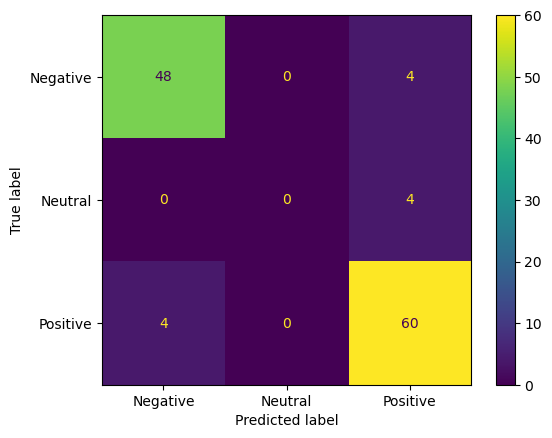

In [9]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Negative', 'Neutral', 'Positive'])

In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # trying to remove emojis
    #text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove non-alphanumeric characters except "æ, ø, å" and their uppercase counterparts
    text = re.sub(r'[^a-zA-ZæøåÆØÅ\s]', '', text)
    return text.strip()

# Preprocessing  text by removing emojis and non-alphanumeric characters
data['preprocessed_text'] = data['body'].apply(lambda text: preprocess_text(text))

# Lemmatization
lemmatizer = WordNetLemmatizer()
data['lemmatized_texts'] = data['preprocessed_text'].apply(lambda text: [lemmatizer.lemmatize(token) for token in word_tokenize(text)])

# Convert the lemmatized texts back to string representation
data['lemmatized_texts'] = data['lemmatized_texts'].apply(lambda tokens: ' '.join(tokens))


In [5]:
data.head(10)

,company,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg\r,preprocessed_text,lemmatized_texts
0,UPS,forkert adresse måtte selv hente den det rigti...,"Jeg bestilte nogle Nike sko, hvorefter der sto...",1,-1,neutral,0.011,0.986,0.003,Jeg bestilte nogle Nike sko hvorefter der stod...,"[Jeg, bestilte, nogle, Nike, sko, hvorefter, d..."
1,UPS,Værste amatør nogensinde,Værste amatør nogensinde. Allerede flere gange...,1,-1,negative,0.002,0.001,0.998,Værste amatør nogensinde Allerede flere gange ...,"[Værste, amatør, nogensinde, Allerede, flere, ..."
2,UPS,Virkelig tynd kundeservice,Virkelig tynd kundeservice. Kan ikke sende et ...,1,-1,negative,0.022,0.001,0.978,Virkelig tynd kundeservice Kan ikke sende et s...,"[Virkelig, tynd, kundeservice, Kan, ikke, send..."
3,PostNord i Danmark,Præcision og hurtig levering,Præcision og hurtig levering,5,1,positive,0.914,0.081,0.004,Præcision og hurtig levering,"[Præcision, og, hurtig, levering]"
4,UPS,"😡 UPS, aldrig igen!",Hold da op!Hvad sker der for UPS? Kundeservice...,1,-1,positive,0.798,0.110,0.092,Hold da opHvad sker der for UPS Kundeservice e...,"[Hold, da, opHvad, sker, der, for, UPS, Kundes..."
5,PostNord i Danmark,Meget tilfreds 👍👍,Meget tilfreds 👍👍,5,1,positive,0.999,0.000,0.001,Meget tilfreds,"[Meget, tilfreds]"
6,PostNord i Danmark,Jeg har ikke modtaget pakken og den er…,Jeg har ikke modtaget pakken og den er ikke de...,1,-1,neutral,0.001,0.996,0.003,Jeg har ikke modtaget pakken og den er ikke de...,"[Jeg, har, ikke, modtaget, pakken, og, den, er..."
7,PostNord i Danmark,Hurtig levering,Hurtig levering. Hvad mere kan man forlange,5,1,positive,0.985,0.013,0.002,Hurtig levering Hvad mere kan man forlange,"[Hurtig, levering, Hvad, mere, kan, man, forla..."
8,PostNord i Danmark,God og hurtig levering lige til døren,God og hurtig levering lige til døren. Punktli...,5,1,positive,0.997,0.001,0.002,God og hurtig levering lige til døren Punktlig...,"[God, og, hurtig, levering, lige, til, døren, ..."
9,FedEx,Jeg har lige vundet en hel palle…,"Jeg har lige vundet en hel palle køkkengrej, t...",1,-1,negative,0.008,0.002,0.990,Jeg har lige vundet en hel palle køkkengrej ti...,"[Jeg, har, lige, vundet, en, hel, palle, køkke..."


### Wanted to see if it made a difference if the text was cleaned a bit more and compare it to the results above, but right now it removes æ,ø and å. Which it is not suposed to do. It removes emojis tho.

In [15]:
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Loadings the pre-trained Danish language model
nlp = spacy.load("da_core_news_sm")

# Splitting the data into training and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Extract named entities from the text data
train_named_entities = train_data['body'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])
test_named_entities = test_data['body'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

# Converting named entities to text
train_text_with_entities = train_named_entities.apply(lambda entities: ' '.join([entity[0] for entity in entities]))
test_text_with_entities = test_named_entities.apply(lambda entities: ' '.join([entity[0] for entity in entities]))

# Vectorize the text data with named entities
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_text_with_entities)
test_vectors = vectorizer.transform(test_text_with_entities)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_vectors, train_data['sentiment'])

# Predict sentiment for a new review with named entities
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_entities = [(ent.text, ent.label_) for ent in nlp(new_review).ents]
new_review_text_with_entities = ' '.join([entity[0] for entity in new_review_entities])
new_review_vector = vectorizer.transform([new_review_text_with_entities])
predicted_sentiment = clf.predict(new_review_vector)[0]

sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

# Print the predicted sentiment
if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")


sentiment
 1    332
-1    250
 0     18
Name: count, dtype: int64
Positive sentiment


In [16]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.92      0.44      0.60        52
     Neutral       0.00      0.00      0.00         4
    Positive       0.65      0.97      0.78        64

    accuracy                           0.71       120
   macro avg       0.52      0.47      0.46       120
weighted avg       0.75      0.71      0.67       120



/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)